# Data Augmentation experiments

## Imports and data read

In [82]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from openai import OpenAI

from sklearn.model_selection import train_test_split

## Pipeline

https://platform.openai.com/docs/api-reference/authentication

In [2]:
api_key = 'sk-proj-7yyg4KC696T7WK6CmLeWT3BlbkFJfjiC6bs5r8R7yoGLCIUP'

In [3]:
client = OpenAI(api_key=api_key)

In [5]:
df = pd.read_parquet('./data_provided/final_dataset/final_17042025.parquet')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12224 entries, 0 to 12223
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   response_id           12224 non-null  int64 
 1   document_id           12224 non-null  int64 
 2   user_id               12224 non-null  int64 
 3   annotator_sentiment   12224 non-null  object
 4   is_ck_annotation      12224 non-null  int64 
 5   response_timestamp    12224 non-null  object
 6   document_content      12224 non-null  object
 7   annotation_date       12224 non-null  object
 8   username              12224 non-null  object
 9   unique_document_id    12224 non-null  object
 10  language_wc           12224 non-null  object
 11  document_length       12224 non-null  int64 
 12  gpt_labels_v1         12224 non-null  object
 13  language_gpt          12224 non-null  object
 14  language_manual       12224 non-null  object
 15  language              12224 non-null

In [7]:
df.language.unique()

array(['ua', 'ru', 'mixed'], dtype=object)

## Stratification label balancing

The core idea is to reduce the imbalance between classes in the dataset by generating new samples by Chat GPT

In [8]:
df.stratification_label.value_counts()

stratification_label
neutral_ua        3291
negative_ua       2433
positive_ua       1859
negative_ru       1799
neutral_ru        1208
mixed_ua           442
positive_ru        441
negative_mixed     309
neutral_mixed      203
mixed_ru           120
positive_mixed      73
mixed_mixed         46
Name: count, dtype: int64

In [9]:
max_stratification = df.stratification_label.value_counts().max()

In [10]:
max_stratification

np.int64(3291)

In [11]:
classes_to_augment = (df.stratification_label.value_counts() - max_stratification).reset_index()

In [12]:
classes_to_augment['count'] = classes_to_augment['count'].apply(abs) 

In [13]:
classes_to_augment

,stratification_label,count
0,neutral_ua,0
1,negative_ua,858
2,positive_ua,1432
3,negative_ru,1492
4,neutral_ru,2083
5,mixed_ua,2849
6,positive_ru,2850
7,negative_mixed,2982
8,neutral_mixed,3088
9,mixed_ru,3171


In [14]:
classes_to_augment['count'].sum()

np.int64(27268)

In [20]:
# for text in df.loc[(df.stratification_label == 'mixed_mixed'), 'document_content']:
#     pprint.pprint(text, width=250)
#     print('----------------------------')
#     print('----------------------------')
#     print('----------------------------')

In [ ]:
def analyze_sentiment(comment, system_prompt):
    """
    Sends a request to OpenAI's GPT model to analyze sentiment.
    """
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": comment}
        ]
    )   
    return response.choices[0].message.content

In [15]:
prompt_inputs = {
    'negative_ua': [858, 'include only Ukrainian words', 'negative sentiment'],
    'positive_ua': [1432, 'include only Ukrainian words', 'positive sentiment'],
    'negative_ru': [1492, 'include only Russian words', 'negative sentiment'],
    'neutral_ru': [2083, 'include only Russian words', 'neutral sentiment'],
    'mixed_ua': [2849, 'include only Ukrainian words', 'mixed sentiment (express positive and negative emotions in different part of the text output'],
    'positive_ru': [2850, 'include only Russian words', 'positive sentiment'],
    'negative_mixed': [2982, 'include Ukrainian words as well as Russian (e.g.: "Доброго вечора, как делишки?")', 'negative sentiment'],
    'neutral_mixed': [3088, 'include Ukrainian words as well as Russian (e.g.: "Доброго вечора, как делишки?")', 'neutral sentiment'],
    'mixed_ru': [3171, 'include only Russian words', 'mixed sentiment (express positive and negative emotions in different part of the text output'],
    'positive_mixed': [3218, 'include Ukrainian words as well as Russian (e.g.: "Доброго вечора, как делишки?")', 'positive sentiment'],
    'mixed_mixed': [3245, 'include Ukrainian words as well as Russian (e.g.: "Доброго вечора, как делишки?")', 'mixed sentiment (express positive and negative emotions in different part of the text output)'],

}

In [16]:
prompt_outputs = {
    
}

In [ ]:
for strat_label, inputs in tqdm(prompt_inputs.items()):

    prompt_outputs[strat_label] = []
    
    for _ in tqdm(range(inputs[0])):
        language = inputs[1]
        sentiment = inputs[2]
        text = df.loc[(df.stratification_label == strat_label), 'document_content'].sample(1).values[0]
        


        system_prompt_overall = f'''

                You are a sentiment analysis expert. You need to help to create a dataset of texts needed for training an ML model. Your help is to write a text which will be included to the dataset. This is important that the text must {language}. The sentiment of the text should express {sentiment}.
                The example of such a text is provided below.

                Write the text similar to the provided example. You can do just a rewording. However, remember, that the resulted text must {language}. 
                
                Also, uou must write only the text without any additional comments from yourself. 

            '''
        
        comment = f'''

        The text example is below: 
        """
        {text}
        """

        '''

        prompt_outputs[strat_label].append(analyze_sentiment(comment, system_prompt=system_prompt_overall))



100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


In [ ]:
import pickle

def save_prompt_outputs(prompt_outputs, filename='prompt_outputs.pkl'):
    """
    Save the prompt_outputs dictionary to a pickle file.
    
    Args:
        prompt_outputs (dict): The dictionary containing the outputs to save
        filename (str): Name of the pickle file to save to (default: 'prompt_outputs.pkl')
    
    Returns:
        bool: True if the save was successful, False otherwise
    """
    try:
        with open(filename, 'wb') as file:
            pickle.dump(prompt_outputs, file)
        print(f"Successfully saved prompt_outputs to {filename}")
        return True
    except Exception as e:
        print(f"Error saving prompt_outputs: {e}")
        return False

In [ ]:
save_prompt_outputs(prompt_outputs, filename='prompt_outputs.pkl')

In [ ]:
df_augmented = pd.DataFrame({'stratification_label':[], 
             'document_content': []})

In [ ]:
for strat_label, texts in tqdm(prompt_outputs.items()):
    temp_df = pd.DataFrame({'stratification_label':[strat_label for i in range(len(texts))], 
             'document_content': texts})

    df_augmented = pd.concat([df_augmented, temp_df], ignore_index=True)

In [ ]:
df_augmented.to_parquet('augmentations.parquet')

## New dataset creation

In [10]:
df_augmented = pd.read_parquet('./data_provided/final_dataset/augmentations.parquet')

In [15]:
df_augmented['language'] = df_augmented['stratification_label'].str[-2:]

In [19]:
df_augmented.language = df_augmented.language.apply(lambda x: {'ua': 'ua', 'ru': 'ru', 'ed': 'mixed'}[x])

In [21]:
df_augmented['username'] = 'gpt'

In [29]:
df_augmented['annotator_sentiment'] = df_augmented['stratification_label'].str[0:6]

In [30]:
df_augmented.annotator_sentiment = df_augmented.annotator_sentiment.apply(lambda x: {'negati': 'negative', 
                                                                                     'positi': 'positive', 
                                                                                     'neutra': 'neutral', 
                                                                                     'mixed_': 'mixed'}[x])

In [35]:
df_augmented['user_id'] = -1

In [40]:
df_augmented['document_id'] = [i for i in range(len(df_augmented))]

In [42]:
df_augmented['document_id'] = df_augmented['document_id']+13000

In [45]:
df_augmented['document_length'] = df_augmented.document_content.apply(len)

In [48]:
df_augmented['is_ck_annotation'] = 0

In [59]:
df_augmented['unique_document_id'] = df_augmented.apply(lambda x: str(x['document_id']) + "_" + str(x['is_ck_annotation']), axis=1)

In [61]:
df_augmented

,stratification_label,document_content,language,username,annotator_sentiment,user_id,document_id,document_length,is_ck_annotation,unique_document_id
0,negative_ua,"Мені так сумно, коли доводиться чекати в черзі...",ua,gpt,negative,-1,13000,99,0,13000_0
1,negative_ua,Ужасно! Це жахливо... Гірше ніж я собі уявляв.,ua,gpt,negative,-1,13001,46,0,13001_0
2,negative_ua,Замовлення піца було розчаруванням,ua,gpt,negative,-1,13002,34,0,13002_0
3,negative_ua,"Зранку прокинулась, а за вікном лише хмари й дощ.",ua,gpt,negative,-1,13003,49,0,13003_0
4,negative_ua,Гидко виглядає,ua,gpt,negative,-1,13004,14,0,13004_0
...,...,...,...,...,...,...,...,...,...,...
27263,mixed_mixed,"Антон був розчарований, коли дізнався, що зако...",mixed,gpt,mixed,-1,40263,268,0,40263_0
27264,mixed_mixed,"Вітаю, як ваші справи? Недавно була у чудовому...",mixed,gpt,mixed,-1,40264,425,0,40264_0
27265,mixed_mixed,Україна вибачається за велику кількість корупц...,mixed,gpt,mixed,-1,40265,314,0,40265_0
27266,mixed_mixed,У нас чудовий настрій сьогодні! Я вже втомився...,mixed,gpt,mixed,-1,40266,115,0,40266_0


In [12]:
df = pd.read_parquet('./data_provided/final_dataset/final_17042025.parquet')

In [65]:
test_df = df.loc[df.df_set == 'test', :].copy()

In [86]:
test_df.loc[test_df.annotator_sentiment == 'mixed', :].shape

(60, 18)

In [84]:
for text in test_df.loc[test_df.annotator_sentiment == 'mixed', 'document_content']:
    pprint.pprint(text, width=250)
    print('-------------------------')
    print('-------------------------')
    print('-------------------------')

'Пентагон спростував заяви МО рФ Шойгу про знищення 6 установок HIMARS, — Reuters.  “Нам відомо про ці останні заяви міністра Шойгу, і вони знову явно помилкові”.'
-------------------------
-------------------------
-------------------------
('Автор ГОВОРИТ ВАМ ПРАВДУ и ПРОБЛЕМА В ТОМ, ЧТО ЭТА ПРАВДА ТАКАЯ НЕУДОБОВАРИМАЯ ДЛЯ ОБЫВАТЕЛЯ,  НО ОТ ЭТОГО ПРАВДА НЕ ПЕРЕСТАЕТ БЫТЬ ПРАВДОЙ даже если она вам не нравится, ,,,,,  !!!!   На самом деле всё не так , как может казаться.  ВСЕ ЗАКОНЫ '
 'ПОПРАНЫ И КОНСТИТУЦИЯ В ТОМ ЧИСЛЕ --- ЭЛИТА ИГРАЕТ В ГРЯЗНЫЕ ИГРЫ С НАРОДОМ , А НАРОД  ПРЕДПОЧИТАЕТ ЖИТЬ КАК СТРАУСЫ....     УВЫ,  АВТОР ГОВОРИТ НАМ ТО,  ЧТО ЕСТЬ НА САМОМ ДЕЛЕ !')
-------------------------
-------------------------
-------------------------
'Извини пупсик не буду больше :( ❤️'
-------------------------
-------------------------
-------------------------
('США не верят в угрозу применения россией ядерного оружия, несмотря на недавнюю эскалацию риторики Москвы. Об этом заявил высокопоста

In [66]:
df_to_concat = df.loc[df.df_set != 'test', :].copy()

In [69]:
df_to_concat = df_to_concat.loc[:, df_augmented.columns]

In [70]:
df_augmented_full = pd.concat([df_augmented, df_to_concat], ignore_index=True)

In [72]:
df_augmented_full

,stratification_label,document_content,language,username,annotator_sentiment,user_id,document_id,document_length,is_ck_annotation,unique_document_id
0,negative_ua,"Мені так сумно, коли доводиться чекати в черзі...",ua,gpt,negative,-1,13000,99,0,13000_0
1,negative_ua,Ужасно! Це жахливо... Гірше ніж я собі уявляв.,ua,gpt,negative,-1,13001,46,0,13001_0
2,negative_ua,Замовлення піца було розчаруванням,ua,gpt,negative,-1,13002,34,0,13002_0
3,negative_ua,"Зранку прокинулась, а за вікном лише хмари й дощ.",ua,gpt,negative,-1,13003,49,0,13003_0
4,negative_ua,Гидко виглядає,ua,gpt,negative,-1,13004,14,0,13004_0
...,...,...,...,...,...,...,...,...,...,...
38264,negative_ua,"Краще ""повинна бути зручнішою, ніж Uber чи Boo...",ua,D,negative,467130971,8948,51,0,8948_0
38265,mixed_ua,Увага! З деяких інтернет джерел шириться інфор...,ua,D,mixed,467130971,2094,402,0,2094_0
38266,neutral_ua,"Питання, цей сертифікат можна вже використовув...",ua,D,neutral,467130971,5013,113,0,5013_0
38267,negative_ua,На Вугледарському напрямку загинув Рома Іванен...,ua,D,negative,467130971,4572,114,0,4572_0


In [75]:
def multi_stratified_split(final_df, train_size=0.8, val_size=0.2, random_state=1337):
    """Create train/val/test splits with stratification on multiple variables"""
    
    df = final_df.copy()

    df['stratification_label'] = df['annotator_sentiment'].astype(str) + '_' + \
                   df['language'].astype(str)
    
    # Check if we have enough samples per stratum
    strata_counts = df['stratification_label'].value_counts()
    print(f"Number of unique strata: {len(strata_counts)}")
    print(strata_counts)
    print(f"Minimum samples in a stratum: {strata_counts.min()}")
    
    # First split: training vs. (validation+test)
    train_df, val_df = train_test_split(
        df, 
        train_size=train_size,
        stratify=df['stratification_label'],
        random_state=random_state
    )
    
    return train_df, val_df

In [91]:
train_df, val_df = multi_stratified_split(df_augmented_full)

Number of unique strata: 12
stratification_label
mixed_mixed       3287
positive_mixed    3284
mixed_ru          3279
neutral_mixed     3270
negative_mixed    3260
mixed_ua          3247
positive_ru       3247
neutral_ru        3170
negative_ru       3111
positive_ua       3105
negative_ua       3047
neutral_ua        2962
Name: count, dtype: int64
Minimum samples in a stratum: 2962


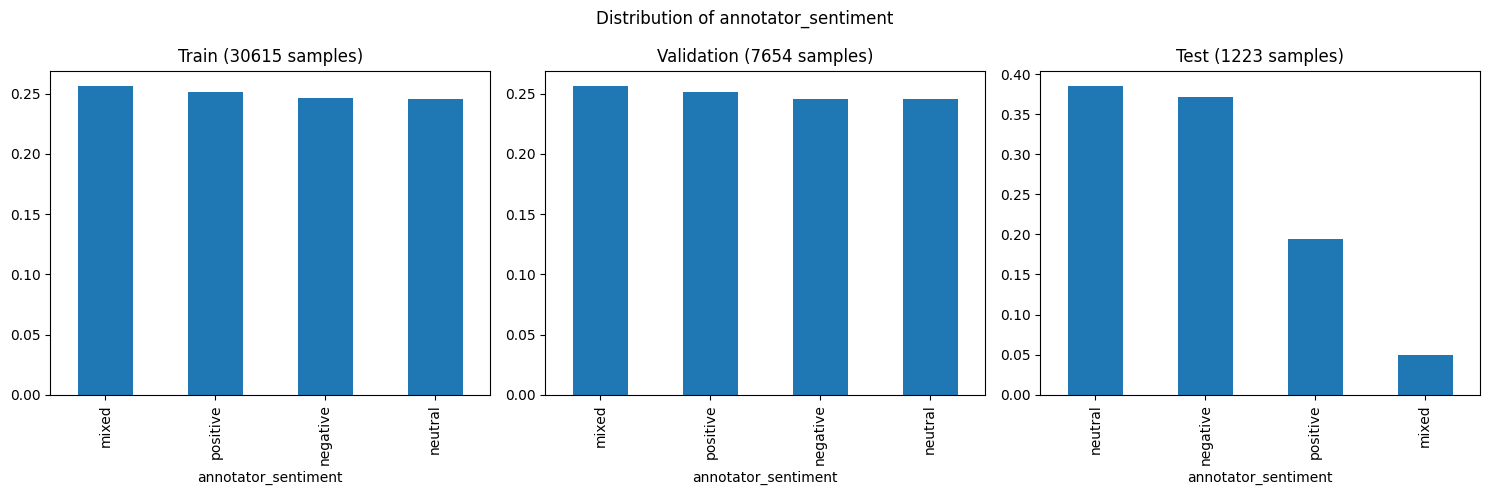

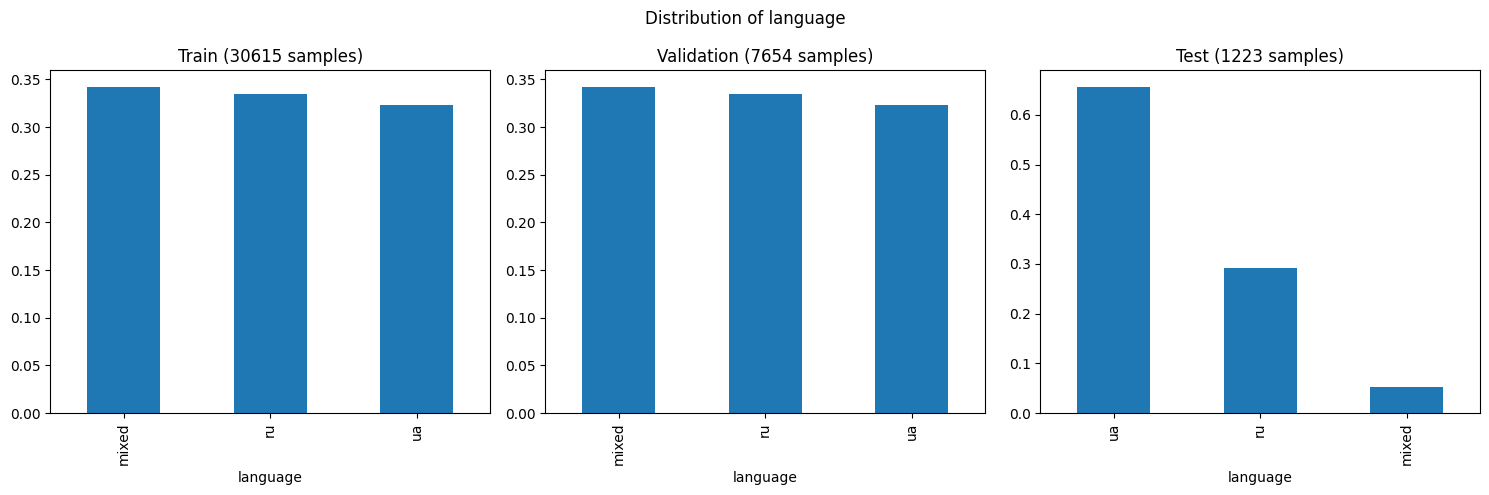

Train set: 30615 samples
Validation set: 7654 samples
Test set: 1223 samples


In [92]:
# Step 4: Verify the distributions
def verify_distributions(train_df, val_df, test_df, columns=['annotator_sentiment', 'language']):
    """Plot distributions to verify they're similar across splits"""
    for col in columns:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        train_dist = train_df[col].value_counts(normalize=True)
        val_dist = val_df[col].value_counts(normalize=True)
        test_dist = test_df[col].value_counts(normalize=True)
        
        train_dist.plot(kind='bar', ax=ax[0], title=f'Train ({len(train_df)} samples)')
        val_dist.plot(kind='bar', ax=ax[1], title=f'Validation ({len(val_df)} samples)')
        test_dist.plot(kind='bar', ax=ax[2], title=f'Test ({len(test_df)} samples)')
        
        fig.suptitle(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()


verify_distributions(train_df, val_df, test_df)

# Now you have your splits ready for BERT fine-tuning
print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

In [93]:
val_df['df_set'] = 'validation'
test_df['df_set'] = 'test'
train_df['df_set'] = 'train'

In [104]:
val_df.columns == train_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [107]:
df_augmented_full_final = pd.concat([val_df, train_df], ignore_index=True)

In [108]:
df_augmented_full_final

,stratification_label,document_content,language,username,annotator_sentiment,user_id,document_id,document_length,is_ck_annotation,unique_document_id,df_set
0,positive_ua,"Треба максимальна підтримка, прошу поширення",ua,D,positive,467130971,3347,44,0,3347_0,validation
1,neutral_ua,Чому на замовлення ватних дисків сьогодні не з...,ua,O,neutral,277133851,1117,68,0,1117_0,validation
2,positive_ru,"""Прекрасное настроение наполняет сердце радост...",ru,gpt,positive,-1,23500,101,0,23500_0,validation
3,positive_mixed,✨ Отримала подарункові сертифікати на будівель...,mixed,gpt,positive,-1,35734,530,0,35734_0,validation
4,negative_ua,"Трохи несправедливо відносяться до молоді. ""Зн...",ua,gpt,negative,-1,13567,200,0,13567_0,validation
...,...,...,...,...,...,...,...,...,...,...,...
38264,mixed_ru,"Тихий вечер, пропитанный запахом свежего хлеба...",ru,gpt,mixed,-1,32829,170,0,32829_0,train
38265,neutral_ua,Помощь Азову,ua,D,neutral,467130971,4339,12,0,4339_0,train
38266,mixed_ua,Отримали нову собаку в подарунок. Цуценя дуже ...,ua,gpt,mixed,-1,21567,117,0,21567_0,train
38267,positive_ru,Москва обстановка,ru,D,positive,467130971,3874,17,0,3874_0,train


In [109]:
df_augmented_full_final = pd.concat([df_augmented_full_final, test_df.loc[:, df_augmented_full_final.columns]], ignore_index=True)

In [110]:
df_augmented_full_final.df_set.value_counts()

df_set
train         30615
validation     7654
test           1223
Name: count, dtype: int64

In [ ]:
df_augmented_full_final

,stratification_label,document_content,language,username,annotator_sentiment,user_id,document_id,document_length,is_ck_annotation,unique_document_id,df_set
0,positive_ua,"Треба максимальна підтримка, прошу поширення",ua,D,positive,467130971,3347,44,0,3347_0,validation
1,neutral_ua,Чому на замовлення ватних дисків сьогодні не з...,ua,O,neutral,277133851,1117,68,0,1117_0,validation
2,positive_ru,"""Прекрасное настроение наполняет сердце радост...",ru,gpt,positive,-1,23500,101,0,23500_0,validation
3,positive_mixed,✨ Отримала подарункові сертифікати на будівель...,mixed,gpt,positive,-1,35734,530,0,35734_0,validation
4,negative_ua,"Трохи несправедливо відносяться до молоді. ""Зн...",ua,gpt,negative,-1,13567,200,0,13567_0,validation
...,...,...,...,...,...,...,...,...,...,...,...
39487,negative_ru,"Дом напротив муз.училища.Фото старое,дома уже нет",ru,D,negative,467130971,10308,49,0,10308_0,test
39488,negative_ua,Розумію так. За неявку без поважної причини по...,ua,D,negative,467130971,5930,998,0,5930_0,test
39489,neutral_ua,фізичне та ментальне відновлення 3️⃣Економічна...,ua,D,neutral,467130971,11410,461,0,11410_0,test
39490,negative_ua,Німеччина передасть Україні сучасні ППО та рад...,ua,D,negative,467130971,2967,266,0,2967_0,test


In [112]:
df_augmented_full_final.to_parquet('./data_provided/final_dataset/df_augmented_full_final.parquet')